In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf

from scipy.special import logsumexp

In [2]:
%load_ext watermark
az.style.use("arviz-darkgrid")
np.random.seed(1211)

#### Code 7.1

In [3]:
sppnames = ["afarensis", "africanus", "habilis", "boisei", "rudolfensis", "ergaster", "sapiens"]
brainvolcc = [438, 452, 612, 521, 752, 871, 1350]
masskg =  [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]

d = pd.DataFrame.from_dict({"species": sppnames, "brain": brainvolcc, "mass": masskg})
d

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


#### Code 7.2

In [4]:
d["mass_std"] = (d["mass"] - d["mass"].mean()) / d["mass"].std()
d["brain_std"] = d["brain"] / d["brain"].max()

#### Code 7.3

In [5]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0.5, sd=1),
    "mass_std": bmb.Prior("Normal", mu=0, sd=10),
    "sigma": bmb.Prior("Exponential", lam=1),
}

model_7_1 = bmb.Model("brain_std ~ mass_std", d, priors=priors)
results_7_1 = model_7_1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [brain_std_sigma, mass_std, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


#### Code 7.4

In [6]:
model_7_1_OLS = smf.ols("brain_std ~ mass_std", data=d).fit()
mean = model_7_1_OLS.params.values
cov = np.diag(model_7_1_OLS.cov_params())
post = stats.multivariate_normal.rvs(mean=mean, cov=cov, size=10000)

#### Code 7.5

In [7]:
def var2(x):
    return np.mean(x ** 2) - np.mean(x) ** 2

In [8]:
model_7_1.posterior_predictive(results_7_1, 1000)

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [9]:
r = results_7_1.posterior_predictive["brain_std"].values.reshape(-1, 7).mean(axis=0) - d["brain_std"].values
resid_var = var2(r)
outcome_var = var2(d["brain_std"])
1 - resid_var / outcome_var

0.5062199789556512

#### Code 7.6

In [10]:
def R2_is_bad(model, result):
    model.posterior_predictive(result, 1000)
    r = result.posterior_predictive["brain_std"].values.reshape(-1, 7).mean(axis=0) - d["brain_std"].values
    return 1 - var2(r) / var2(d["brain_std"])

#### Code 7.7

Here we use the `common` key in the priors dictionary. This means that all the common predictors (fixed effects) are going to receive the same prior, a normal with mean 0 and sd of 10, as our inspection below confirms. We also start with a baseline formula, and add terms to the formula as we create models.

In [11]:
formula = "brain_std ~ mass_std + I(mass_std ** 2)"
priors = {
    "Intercept": bmb.Prior("Normal", mu=0.5, sd=1),
    "common": bmb.Prior("Normal", mu=0, sd=10),
    "sigma": bmb.Prior("Exponential", lam=1),
}

In [12]:
model_7_2 = bmb.Model(formula, d, priors=priors)
model_7_2

Formula: brain_std ~ mass_std + I(mass_std ** 2)
Family name: Gaussian
Link: identity
Observations: 7
Priors:
  Intercept ~ Normal(mu: 0.5, sd: 1)
  mass_std ~ Normal(mu: 0, sd: 10)
  I(mass_std ** 2) ~ Normal(mu: 0, sd: 10)
  sigma ~ Exponential(lam: 1)

In [13]:
formula += " + I(mass_std ** 3)"
model_7_3 = bmb.Model(formula, d, priors=priors)
formula += " + I(mass_std ** 4)"
model_7_4 = bmb.Model(formula, d, priors=priors)
formula += " + I(mass_std ** 5)"
model_7_5 = bmb.Model(formula, d, priors=priors)
formula += " + I(mass_std ** 6)"
model_7_6 = bmb.Model(formula, d, priors=priors)

I'm skipping this for now, until we have better Laplace method.

#### Code 7.12

In [14]:
p = np.array([0.3, 0.7])
-np.sum(p * np.log(p))

0.6108643020548935

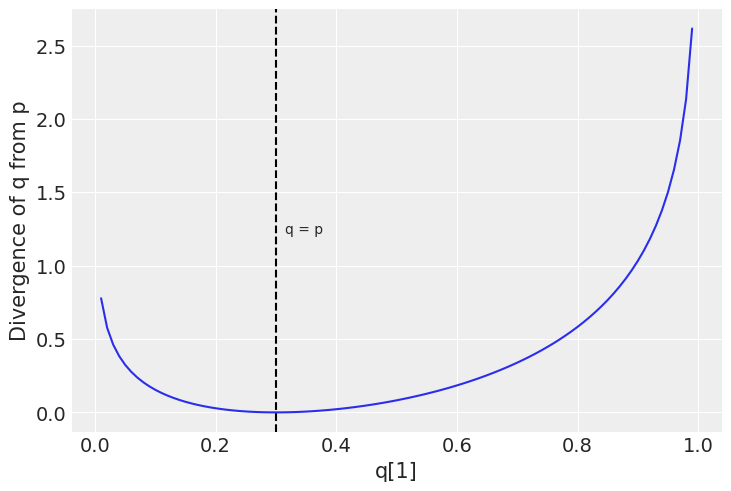

In [15]:
# Figure 7.5
p = np.array([0.3, 0.7])
q = np.arange(0.01, 1, 0.01)
DKL = np.sum(p * np.log(p / np.array([q, 1 - q]).T), 1)

plt.plot(q, DKL)
plt.xlabel("q[1]")
plt.ylabel("Divergence of q from p")
plt.axvline(0.3, ls="dashed", color="k")
plt.text(0.315, 1.22, "q = p");

#### Code 7.13 & 7.14

We don't have a `lppd()` function, but we can extract the log-likelihood and finish the computation ourselves. T

In [16]:
logprob = results_7_1.log_likelihood["brain_std"].stack(sample=["chain", "draw"]).values.reshape((7, 2000))

n = logprob.shape[0]
ns = logprob.shape[1] 

lppd = np.zeros(n)
for i in range(n):
    lppd[i] = logsumexp(logprob[i]) - np.log(ns)
lppd

array([ 0.46031432,  0.49022383,  0.39503769,  0.47387998,  0.33126112,
        0.28998899, -0.67546589])

#### Code 7.15 to Code 7.18

We don't have the means to do these tasks well in Bambi yet.

#### Code 7.19

In [17]:
data = pd.read_csv("data/cars.csv")
data.head()

,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


In [18]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=100),
    "mass_std": bmb.Prior("Normal", mu=0, sd=10),
    "sigma": bmb.Prior("Exponential", lam=1),
}

m = bmb.Model("dist ~ speed", data, priors=priors)
results_m = m.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [dist_sigma, speed, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


#### Code 7.20

In [19]:
post = results_m.posterior.stack(sample=["chain", "draw"])
a = post["Intercept"].values
b = post["speed"].values
sigma = post["dist_sigma"].values

In [20]:
n_samples = 1000
n_cases = data.shape[0]
logprob = np.zeros((n_cases, n_samples))

for s in range(n_samples):
    mu = a[s] + b[s] * data["speed"]
    logprob[:, s] = stats.norm.logpdf(data["dist"], loc=mu, scale=sigma[s])

#### Code 7.21

We have an array with shape `(50, 1000)`. We apply the `logsumexp()` funcion on `axis=1` to return an array of shape `(50,)`

In [21]:
lppd = logsumexp(logprob, 1) - np.log(n_samples)

#### Code 7.22

Similar idea here

In [22]:
pWAIC = np.var(logprob, axis=1)

#### Code 7.23

In [23]:
-2 * (np.sum(lppd) - np.sum(pWAIC))

421.24274061937064

#### Code 7.24

In [24]:
waic_vec = -2 * (lppd - pWAIC)
np.sqrt(n_cases * np.var(waic_vec))

16.317728486436113

#### Setup for Code 7.25+

We need to obtain models `model_6_6`, `model_6_7`, and `model_6_8` from previous chapter.

In [25]:
# number of plants
N = 100

# simulate initial heights
h0 = np.random.normal(10, 2, N)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)

# compose a clean data frame
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})
az.summary(d.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
h0,9.903,2.003,6.476,14.276
h1,14.191,2.418,8.693,18.207
treatment,0.500,0.503,0.000,1.000
fungus,0.250,0.435,0.000,1.000


In [26]:
priors = {
    "h0": bmb.Prior("Lognormal", mu=0, sigma=0.25),
    "sigma": bmb.Prior("Exponential", lam=1),
}
model_6_6 = bmb.Model("h1 ~ 0 + h0", d, priors=priors)
results_6_6 = model_6_6.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [h1_sigma, h0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


In [27]:
priors = {
    "h0": bmb.Prior("Lognormal", mu=0, sigma=0.2),
    "h0:treatment": bmb.Prior("Normal", mu=0, sd=0.5),
    "h0:fungus": bmb.Prior("Normal", mu=0, sd=0.5),
    "sigma": bmb.Prior("Exponential", lam=1),
}
model_6_7 = bmb.Model("h1 ~ 0 + h0 + h0:treatment + h0:fungus", d, priors=priors)
results_6_7 = model_6_7.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [h1_sigma, h0:fungus, h0:treatment, h0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


In [28]:
priors = {
    "h0": bmb.Prior("Lognormal", mu=0, sigma=0.2),
    "h0:treatment": bmb.Prior("Normal", mu=0, sd=0.5),
    "sigma": bmb.Prior("Exponential", lam=1),
}
model_6_8 = bmb.Model("h1 ~ 0 + h0 + h0:treatment", d, priors=priors)
results_6_8 = model_6_8.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [h1_sigma, h0:treatment, h0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


#### Code 7.25

In [29]:
az.waic(results_6_7, scale = "deviance")

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:1406: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 by 100 log-likelihood matrix

              Estimate       SE
deviance_waic   321.09    12.22
p_waic            3.73        -

There has been a warning during the calculation. Please check the results.

#### Code 7.26

In [30]:
compare_df = az.compare(
    {
        "model_6_6": results_6_6,
        "model_6_7": results_6_7,
        "model_6_8": results_6_8,
    },
    ic="waic",
    scale="deviance",
)
compare_df

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:1406: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:1406: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:1406: UserWarning: For one or more samples the posterior variance of the log predic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_6_7,0,321.094660,3.733966,0.000000,1.000000e+00,12.218020,0.000000,True,deviance
model_6_8,1,376.411366,3.221266,55.316706,0.000000e+00,14.339417,11.273896,True,deviance
model_6_6,2,384.832482,2.265256,63.737822,8.302248e-13,15.524433,13.298590,True,deviance


#### Code 7.27

In [31]:
waic_m_6_7 = az.waic(results_6_7, pointwise=True, scale="deviance")
waic_m_6_8 = az.waic(results_6_8, pointwise=True, scale="deviance")

# pointwise values are stored in the waic_i attribute.
diff_m_6_7_m_6_8 = waic_m_6_7.waic_i - waic_m_6_8.waic_i

n = len(diff_m_6_7_m_6_8)

np.sqrt(n * np.var(diff_m_6_7_m_6_8)).values

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:1406: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:1406: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


array(11.27389615)

#### Code 7.28

We use the values from our models, 11.27 for the standard error and 55.35 for the difference between the WAIC of the two models.

In [32]:
55.32 + np.array([-1, 1]) * 11.27 * 2.6

array([26.018, 84.622])

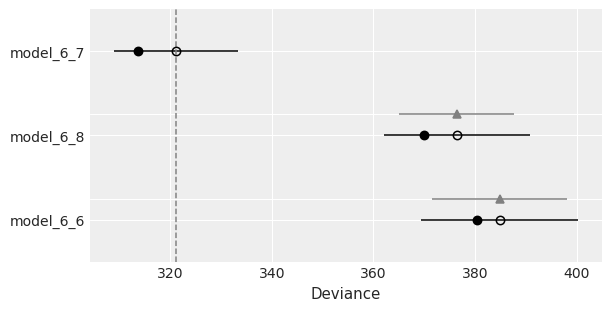

In [33]:
az.plot_compare(compare_df);

#### Code 7.30

In [34]:
waic_m_6_6 = az.waic(results_6_6, pointwise=True, scale="deviance")
diff_m6_6_m6_8 = waic_m_6_6.waic_i - waic_m_6_8.waic_i
n = len(diff_m6_6_m6_8)
np.sqrt(n * np.var(diff_m6_6_m6_8)).values

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:1406: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


array(6.39613523)

#### Code 7.31

dSE is calculated by compare above, but rethinking produces a pairwise comparison. This is not implemented in arviz, but we can hack it together:

In [35]:
dataset_dict = {"model_6_6": results_6_6, "model_6_7": results_6_7, "model_6_8": results_6_8}

# compare all models
s0 = az.compare(dataset_dict, ic="waic", scale="deviance")["dse"]
# the output compares each model to the 'best' model - i.e. two models are compared to one.
# to complete a pair-wise comparison we need to compare the remaining two models.

# to do this, remove the 'best' model from the input data
del dataset_dict[s0.index[0]]

# re-run compare with the remaining two models
s1 = az.compare(dataset_dict, ic="waic", scale="deviance")["dse"]

# s0 compares two models to one model, and s1 compares the remaining two models to each other
# now we just nee to wrangle them together!

# convert them both to dataframes, setting the name to the 'best' model in each `compare` output.
# (i.e. the name is the model that others are compared to)
df_0 = s0.to_frame(name=s0.index[0])
df_1 = s1.to_frame(name=s1.index[0])

# merge these dataframes to create a pairwise comparison
pd.merge(df_0, df_1, left_index=True, right_index=True)

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:1406: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:1406: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:1406: UserWarning: For one or more samples the posterior variance of the log predic

,model_6_7,model_6_8
model_6_8,11.273896,0.000000
model_6_6,13.298590,6.396135


#### Code 7.32

In [36]:
def standardize(x):
    return (x - np.mean(x)) / np.std(x)

In [37]:
d = pd.read_csv("data/WaffleDivorce.csv")
d["A"] = standardize(d["MedianAgeMarriage"])
d["D"] = standardize(d["Divorce"])
d["M"] = standardize(d["Marriage"])

In [38]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=0.2),
    "A": bmb.Prior("Normal", mu=0, sd=0.5),
    "M": bmb.Prior("Normal", mu=0, sd=0.5),
    "sigma": bmb.Prior("Exponential", lam=1),
}

model_5_1 = bmb.Model("D ~ A", d, priors=priors)
results_5_1 = model_5_1.fit()

model_5_2 = bmb.Model("D ~ M", d, priors=priors)
results_5_2 = model_5_2.fit()

model_5_3 = bmb.Model("D ~ M + A", d, priors=priors)
results_5_3 = model_5_3.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [D_sigma, A, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [D_sigma, M, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [D_sigma, A, M, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8802196963185166, but should be close to 0.8. Try to increase the number of tuning steps.


#### Code 7.33

In [39]:
az.compare(
    {"model_5_1": results_5_1, "model_5_2": results_5_2, "model_5_3": results_5_3},
    scale="deviance",
)

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_5_1,0,126.958182,3.721284,0.000000,0.894053,12.741410,0.000000,False,deviance
model_5_3,1,128.774804,4.838442,1.816623,0.000000,12.855868,0.735610,False,deviance
model_5_2,2,140.313353,2.952110,13.355171,0.105947,9.795754,9.225215,False,deviance


#### Code 7.34

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:1406: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


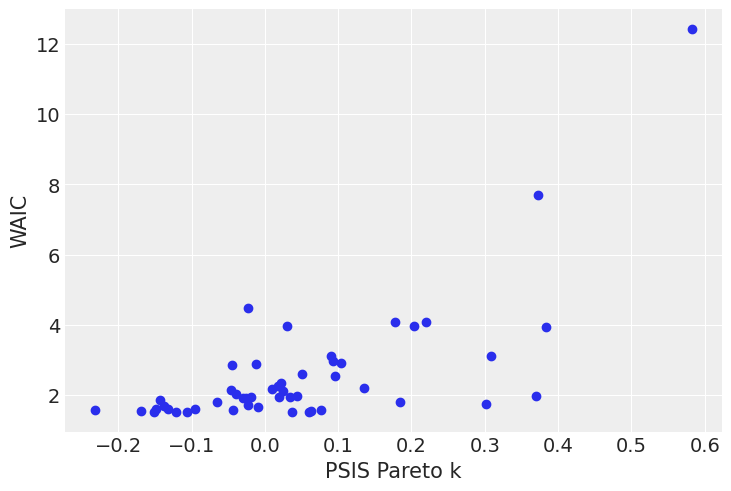

In [40]:
psis = az.loo(results_5_3, pointwise=True, scale="deviance")
waic = az.waic(results_5_3, pointwise=True, scale="deviance")

plt.scatter(psis.pareto_k, waic.waic_i)
plt.xlabel("PSIS Pareto k")
plt.ylabel("WAIC");

#### Code 7.35

Bambi does not support t distribution yet.

In [41]:
%watermark -n -u -v -iv -w

Last updated: Fri May 21 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

statsmodels: 0.12.2
scipy      : 1.5.4
matplotlib : 3.3.3
arviz      : 0.11.2
numpy      : 1.20.1
pandas     : 1.2.2
bambi      : 0.5.0

Watermark: 2.1.0

